# Get the data

In [1]:
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)

In [104]:
def get_data(file, nrows=None):
    if file == 'listings':
        cols = [ 'id',
                 'name',
                 'summary',
                 'space',
                 'description',
                 'experiences_offered',
                 'neighborhood_overview',
                 'notes',
                 'transit',
                 'access',
                 'interaction',
                 'house_rules',
                 'host_since',
                 'host_location',
                 'host_about',
                 'host_response_time',
                 'host_response_rate',
                 'host_neighbourhood',
                 'host_listings_count',
                 'host_total_listings_count',
                 'host_verifications',
                 'host_identity_verified',
                 'street',
                 'neighbourhood_cleansed',
                 'zipcode',
                 'latitude',
                 'longitude',
                 'is_location_exact',
                 'property_type',
                 'room_type',
                 'accommodates',
                 'bathrooms',
                 'bedrooms',
                 'beds',
                 'bed_type',
                 'amenities',
                 'price',
                 'weekly_price',
                 'monthly_price',
                 'security_deposit',
                 'cleaning_fee',
                 'guests_included',
                 'extra_people',
                 'minimum_nights',
                 'maximum_nights',
                 'availability_30',
                 'availability_60',
                 'availability_90',
                 'availability_365',
                 'number_of_reviews',
                 'number_of_reviews_ltm',
                 'first_review',
                 'last_review',
                 'review_scores_rating',
                 'review_scores_accuracy',
                 'review_scores_cleanliness',
                 'review_scores_checkin',
                 'review_scores_communication',
                 'review_scores_location',
                 'review_scores_value',
                 'instant_bookable',
                 'cancellation_policy',
                 'require_guest_profile_picture',
                 'require_guest_phone_verification',
                 'reviews_per_month']
        dates = ['host_since', 'first_review', 'last_review']
        data = pd.read_csv('../data/jan/listings.csv', low_memory=False, parse_dates=dates, usecols=cols,
                           index_col='id', nrows=nrows)
    return data[(data['review_scores_rating'].notna()) & (data['number_of_reviews']>2)]


listings = get_data('listings')

# listings.to_csv('../data/jan/listings_3plus.csv')

In [3]:
fixed_feats = ['host_since', 'host_location', 'host_neighbourhood', 'street', 'neighbourhood_cleansed', 'zipcode',
               'latitude', 'longitude', 'property_type', 'room_type', 'bathrooms', 'bedrooms', 'number_of_reviews']
review_feats = ['number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_accuracy',
                'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 
                'review_scores_location', 'review_scores_value', 'reviews_per_month']
flex_feats = [item for item in listings.columns if (item not in fixed_feats) and (item not in review_feats)] # everything else

In [4]:
listings.shape

(51749, 64)

In [5]:
listings.head(1)

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,host_location,host_about,host_response_time,host_response_rate,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,street,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11551,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,"London, United Kingdom",Lambeth,SW9 8DG,51.46225,-0.11732,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$88.00,$645.00,"$2,350.00",$400.00,$30.00,2,$25.00,2,180,17,42,72,344,186,3,2010-03-21,2019-11-17,92.0,9.0,9.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,f,t,1.56


# Amenities

## Functions

In [144]:
def decode_amenities(df):
    data = df   
    def str_to_list(strn):
        row_items = strn[1:-1].split(',')
        for key,item in enumerate(row_items):
            row_items[key] = item.strip('"').casefold()
        return row_items    
    return data[['amenities']].applymap(str_to_list)

def count_amenities(df):
    data = df
    amenities = decode_amenities(data)
    return amenities.applymap(lambda x: len(x))

def has_amenity(df, name, alias=None):
    data = df
    if not alias:
        alias = name
    amenities = decode_amenities(data)
    col_name = f'has_{alias}'
    amenities[col_name] = amenities[['amenities']].applymap(lambda x: 1 if name.casefold() in x else 0)
    return amenities[[col_name]]

def count_amenity(df, name):
    data = has_amenity(df, name)
    return int(data.sum())

def count_filterables(df, filterables):
    data = decode_amenities(df)
    def apply_count(amenities):
        count = 0
        for item in filterables:
            if isinstance(item, list):
                for x in item:
                    if x.casefold() in amenities:
                        count += 1
                        break
            else:
                if item.casefold() in amenities:
                    count += 1
        return count
    return data.applymap(apply_count)

def encode_filterables(df, filterables):
    data = decode_amenities(df)
    for item in filterables:
        if isinstance(item, list):
            data[''.join([i for i in item[0] if i.isalpha()])] = 0
        else:
            data[''.join([i for i in item if i.isalpha()])] = 0
    encoding = data.drop(columns='amenities').copy()
    for index,column in enumerate(encoding.columns):
        if isinstance(filterables[index], list):
            for item in filterables[index]:
                data[column] =  data[['amenities',column]].apply(
                    lambda x: 1 if item.casefold() in x['amenities'] else 1 if x[column] == 1 else 0,
                    axis=1)
        else:
            data[column] =  data[['amenities']].apply(lambda x: 1 if filterables[index].casefold() in x['amenities'] else 0, axis=1)
    return data.drop(columns='amenities')

In [140]:
filterable_features_localized = ['Free parking on premises', ['Hot tub','shared hot tub','private hot tub'],
                      ['Gym','shared gym'], ['Pool','private pool','shared pool']]
filterable_amenities_localized = [['Kitchen','kitchenette','full kitchen',"chef's kitchen"],'Shampoo','Heating','Air conditioning',
                        ['Washing machine','Washer','Washer / Dryer'],'Dryer','Wifi','Breakfast',
                        'Indoor fireplace','Hangers','Iron','Hair dryer',['Dedicated workspace','laptop friendly workspace'],
                        ['TV', 'cable tv'],['Cot',"Pack 'n Play/travel crib', 'crib"],'High chair',
                        'Self check-in',['Smoke alarm','Smoke detector'],['Carbon monoxide alarm','carbon monoxide detector'],
                        'Private bathroom','Piano']

In [143]:
encode_filterables(listings, filterable_amenities_localized).head()

,amenities,Kitchen,Shampoo,Heating,Airconditioning,Washingmachine,Dryer,Wifi,Breakfast,Indoorfireplace,Hangers,Iron,Hairdryer,Dedicatedworkspace,TV,Cot,Highchair,Selfcheckin,Smokealarm,Carbonmonoxidealarm,Privatebathroom,Piano
id,,,,,,,,,,,,,,,,,,,,,,
11551,"[tv, cable tv, internet, wifi, kitchen, paid p...",1,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0
13913,"[tv, cable tv, wifi, kitchen, paid parking off...",1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0
15400,"[tv, cable tv, internet, wifi, air conditionin...",1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0
17402,"[tv, wifi, kitchen, paid parking off premises,...",1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0
25023,"[tv, wifi, kitchen, free parking on premises, ...",1,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0


## Exploration

In [7]:
localized = [['Washer','Washer / Dryer'], ['Pack ’n Play/travel crib', 'crib'], 'Smoke detector', 'carbon monoxide detector',
            'laptop friendly workspace']

In [49]:
count_filterables(listings, localized)

,amenities
id,
11551,5
13913,5
15400,3
17402,3
25023,4
...,...
41172620,2
41235386,4
41254738,4


In [38]:
filterable_features_localized = ['Free parking on premises', ['Hot tub','shared hot tub','private hot tub'],
                      ['Gym','shared gym'], ['Pool','private pool','shared pool']]
filterable_amenities_localized = [['Kitchen','kitchenette','full kitchen',"chef's kitchen"],'Shampoo','Heating','Air conditioning',
                        ['Washing machine','Washer','Washer / Dryer'],'Dryer','Wifi','Breakfast',
                        'Indoor fireplace','Hangers','Iron','Hair dryer',['Dedicated workspace','laptop friendly workspace'],
                        ['tv', 'cable tv'],['Cot',"Pack 'n Play/travel crib', 'crib"],'High chair',
                        'Self check-in',['Smoke alarm','Smoke detector'],['Carbon monoxide alarm','carbon monoxide detector'],
                        'Private bathroom','Piano']

In [51]:
count_filterables(listings, filterable_amenities_localized)

,amenities
id,
11551,12
13913,13
15400,13
17402,13
25023,11
...,...
41172620,9
41235386,12
41254738,12


In [43]:
listings.loc[25023,'amenities']

'{TV,Wifi,Kitchen,"Free parking on premises",Elevator,"Buzzer/wireless intercom",Heating,Washer,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Hot water",Microwave,"Coffee maker","Dishes and silverware","Host greets you"}'

In [10]:
ams = decode_amenities(listings)
ams.head(5)

,amenities
id,
11551,"[tv, cable tv, internet, wifi, kitchen, paid p..."
13913,"[tv, cable tv, wifi, kitchen, paid parking off..."
15400,"[tv, cable tv, internet, wifi, air conditionin..."
17402,"[tv, wifi, kitchen, paid parking off premises,..."
25023,"[tv, wifi, kitchen, free parking on premises, ..."


In [11]:
amcounts = count_amenities(listings)

In [12]:
ams_bool = has_amenity(listings, 'smoking')

In [13]:
has_amenity(listings, 'tv')

,has_tv
id,
11551,1
13913,1
15400,1
17402,1
25023,1
...,...
41172620,0
41235386,1
41254738,0


In [14]:
ams_ = ams.join(ams_bool)

In [15]:
ams_[ams_['has_smoking'] == 1][['amenities']]

,amenities
id,


In [16]:
count_amenity(listings, 'internet')

13264

<AxesSubplot:ylabel='Count'>

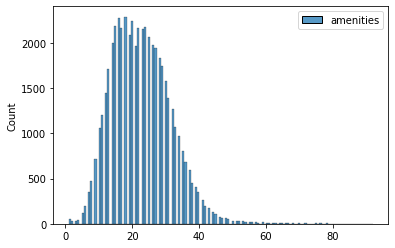

In [17]:
sns.histplot(amcounts)

In [18]:
amcounts.max()

amenities    92
dtype: int64

In [19]:
amcounts.describe()

,amenities
count,51749.000000
mean,22.742101
std,8.875127
min,1.000000
25%,16.000000
50%,22.000000
75%,28.000000
max,92.000000


In [20]:
listings['amcount'] = count_amenities(listings)

In [21]:
listings['has_hotwater'] = has_amenity(listings, 'hot water', 'hotwater')

In [22]:
listings['has_freeparking'] = has_amenity(listings, 'free parking on premises', 'freeparking')

<AxesSubplot:xlabel='review_scores_rating', ylabel='amcount'>

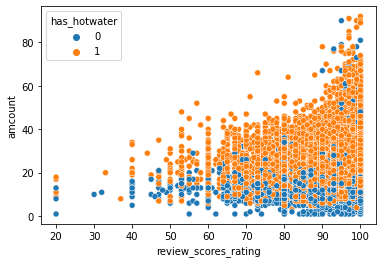

In [23]:
sns.scatterplot(data=listings, x='review_scores_rating', y='amcount', hue='has_hotwater')

<AxesSubplot:xlabel='review_scores_rating', ylabel='amcount'>

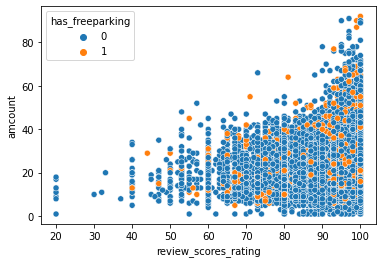

In [24]:
sns.scatterplot(data=listings[listings['number_of_reviews']>2], x='review_scores_rating', y='amcount', hue='has_freeparking')

In [25]:
listings[listings['number_of_reviews']>2][['review_scores_rating','has_freeparking','amcount']].corr()

,review_scores_rating,has_freeparking,amcount
review_scores_rating,1.000000,0.074928,0.149912
has_freeparking,0.074928,1.000000,0.045068
amcount,0.149912,0.045068,1.000000


In [26]:
def get_amenities_list(data):
    av_amenities=[]
    for row in decode_amenities(data)['amenities']:
        for item in row:
            if item not in av_amenities:
                av_amenities.append(item)
    return av_amenities

get_amenities_list(listings)

['tv',
 'cable tv',
 'internet',
 'wifi',
 'kitchen',
 'paid parking off premises',
 'buzzer/wireless intercom',
 'heating',
 'family/kid friendly',
 'washer',
 'smoke detector',
 'carbon monoxide detector',
 'essentials',
 'hangers',
 'hair dryer',
 'iron',
 'laptop friendly workspace',
 'self check-in',
 'lockbox',
 'pack ’n play/travel crib',
 'hot water',
 'long term stays allowed',
 'smoking allowed',
 'free street parking',
 'dryer',
 'fire extinguisher',
 'shampoo',
 'lock on bedroom door',
 'outlet covers',
 'bathtub',
 'children’s books and toys',
 'babysitter recommendations',
 'crib',
 'room-darkening shades',
 'children’s dinnerware',
 'bed linens',
 'extra pillows and blankets',
 'ethernet connection',
 'coffee maker',
 'refrigerator',
 'dishes and silverware',
 'cooking basics',
 'oven',
 'stove',
 'patio or balcony',
 'luggage dropoff allowed',
 'host greets you',
 'handheld shower head',
 'air conditioning',
 '24-hour check-in',
 'translation missing: en.hosting_amenity

In [27]:
filterable_features = ['Free parking on premises', 'Hot tub', 'Gym', 'Pool']
filterable_amenities = ['Kitchen','Shampoo','Heating','Air conditioning','Washing machine','Dryer','Wifi','Breakfast',
                        'Indoor fireplace','Hangers','Iron','Hair dryer','Dedicated workspace','TV','Cot','High chair',
                        'Self check-in','Smoke alarm','Carbon monoxide alarm','Private bathroom','Piano']


In [28]:
for feat in filterable_features:
    print(feat,count_amenity(listings, feat))

Free parking on premises 8426
Hot tub 1502
Gym 1345
Pool 234


In [29]:
for feat in filterable_amenities:
    print(feat,count_amenity(listings, feat))

Kitchen 47270
Shampoo 38804
Heating 50086
Air conditioning 2556
Washing machine 0
Dryer 23282
Wifi 50630
Breakfast 6392
Indoor fireplace 4190
Hangers 44495
Iron 42657
Hair dryer 40785
Dedicated workspace 0
TV 36375
Cot 0
High chair 3162
Self check-in 11675
Smoke alarm 0
Carbon monoxide alarm 0
Private bathroom 27
Piano 0


In [ ]:
listings['bed_type'].value_counts()

In [ ]:
listings[listings['host_total_listings_count'] != listings['host_total_listings_count']]

# Room / bed number ratios

In [57]:
room_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating']
listings[room_cols].corr()

,accommodates,bathrooms,bedrooms,beds,review_scores_rating
accommodates,1.000000,0.471153,0.760621,0.824280,-0.085661
bathrooms,0.471153,1.000000,0.545076,0.482759,-0.005564
bedrooms,0.760621,0.545076,1.000000,0.716056,0.040994
beds,0.824280,0.482759,0.716056,1.000000,-0.065206
review_scores_rating,-0.085661,-0.005564,0.040994,-0.065206,1.000000


In [58]:
room_data = listings[room_cols].copy()

In [145]:
def get_room_ratios(df):
    data = df
    data['accommodates_to_rooms_ratio'] = data['accommodates'] / data['bedrooms']
#     data['accommodates_to_bathrooms_ratio'] = data['accommodates'] / data['bathrooms']
#     data['accommodates_to_beds_ratio'] = data['accommodates'] / data['beds']
#     data['beds_to_rooms_ratio'] = data['beds'] / data['bedrooms']
#     data['beds_to_bathrooms_ratio'] = data['beds'] / data['bathrooms']
    return data[['accommodates_to_rooms_ratio']]

In [146]:
get_room_ratios(room_data).corr()

,accommodates_to_rooms_ratio
accommodates_to_rooms_ratio,1.0


In [150]:
from fivestar import data

In [151]:
listings2 = data.get_data(local=False)

In [153]:
listings2.head(2)

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,host_location,host_about,host_response_time,host_response_rate,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,street,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11551,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,"London, United Kingdom",Lambeth,SW9 8DG,51.46225,-0.11732,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$88.00,$645.00,"$2,350.00",$400.00,$30.00,2,$25.00,2,180,17,42,72,344,186,3,2010-03-21,2019-11-17,92.0,9.0,9.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,f,t,1.56
13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,70%,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,"Islington, Greater London, United Kingdom",Islington,N4 3,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,30,60,90,365,20,6,2010-08-18,2019-11-25,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,moderate,f,f,0.17
